In [ ]:
import torch
torch.set_default_dtype(torch.float64)
import gpytorch

### GAM GP

Efficient implementation of additive kernel

In [ ]:
class AdditiveKernelGP(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, d):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(X_train, y_train, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([d]), ard_num_dims=1)
        )

    def forward(self, X):
        mean = self.mean_module(X)
        batched_dimensions_of_X = X.mT.unsqueeze(-1)  # Now a d x n x 1 tensor
        covar = self.covar_module(batched_dimensions_of_X).sum(dim=-3)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

### Product of univariate kernel

In [ ]:
class ProductKernelGP(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, d):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(X_train, y_train, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([d]), ard_num_dims=1)
        )

    def forward(self, X):
        mean = self.mean_module(X)
        batched_dimensions_of_X = X.mT.unsqueeze(-1)  # Now a d x n x 1 tensor
        covar = self.covar_module(batched_dimensions_of_X).prod(dim=-3)    # Note the prod
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [ ]:
class AdditiveGP(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, d, max_degree):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(X_train, y_train, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([d]), ard_num_dims=1)
        )
        self.max_degree = max_degree

    def forward(self, X):
        mean = self.mean_module(X)
        batched_dimensions_of_X = X.mT.unsqueeze(-1)  # Now a d x n x 1 tensor
        univariate_rbf_covars = self.covar_module(batched_dimensions_of_X)
        covar = gpytorch.utils.sum_interaction_terms(
            univariate_rbf_covars, max_degree=self.max_degree, dim=-3
        )
        covar = covar + torch.eye(*covar.shape) * 1e-6
        return gpytorch.distributions.MultivariateNormal(mean, covar)

# Testing variations of AdditiveGP

In [186]:
import numpy as np
from uci_datasets import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tqdm.notebook

from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean, ZeroMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.metrics import negative_log_predictive_density, mean_squared_error, mean_standardized_log_loss

import os
import sys

sys.path.append('/Users/fllorente/Dropbox/con_Petar/PYTHON/gp_fusion')
from modules.model_training import GPModel


In [187]:
def to_torch(x, dtype=torch.float64):
    if isinstance(x,torch.Tensor):
        return x

    return torch.from_numpy(x).type(dtype)

In [418]:
def multimodal_d_dim(x):
    n, d = x.shape
    centers = [torch.zeros(1, d).to(x) for _ in range(d)]
    for i in range(d):
        centers[i][0,i] = 1.
        centers[i][0,:i] = -1.
        centers[i][0,i+1:] = -1.
    total = 0
    for i in range(d):
        total = total + torch.exp(-torch.norm(x - centers[i], dim=1))
    return total


p = 1   # active dimensions
d = 5  # total dimensions
sn = 0.05

X_train = 5*np.random.randn(100, d)
y_train =  multimodal_d_dim(to_torch(X_train)[:, :p]) + torch.randn(X_train.shape[0]) * sn
y_train = y_train.squeeze()

X_test = 5*np.random.randn(500, d)
y_test = multimodal_d_dim(to_torch(X_test)[:, :p]) #+ torch.randn(X_test.shape[0]) * sn
y_test = y_test.squeeze()

mean, std = X_train.mean(0), X_train.std(0)
X_train = (X_train - mean)/ std
X_test = (X_test - mean)/ std

mean, std = y_train.mean(0), y_train.std(0)
y_train = (y_train - mean)/ std
y_test = (y_test - mean)/ std

In [445]:
p = 1   # active dimensions
d = 5   # total dimensions
sn = 0.01

X_train = np.random.randn(100, d)
y_train = np.sin(X_train[:,:p]).sum(axis=1) + np.random.randn(100) * sn
X_test = np.random.randn(500, d)
y_test = np.sin(X_test[:,:p]).sum(axis=1) + np.random.randn(500) * sn
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [446]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((100, 5), (100,), (500, 5), (500,))

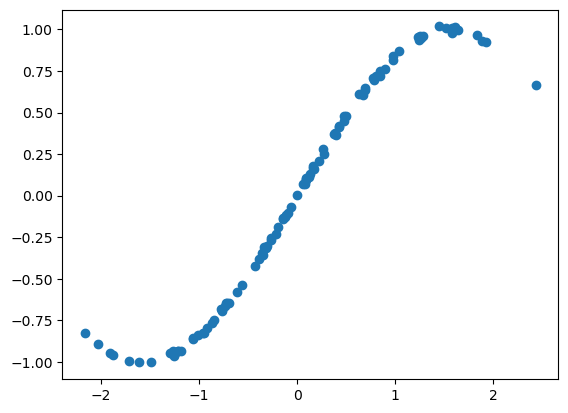

In [447]:
plt.scatter(X_train[:,0],y_train)

Standard GP

In [448]:
likelihood = GaussianLikelihood()
model = GPModel(to_torch(X_train), to_torch(y_train), likelihood, 
                # mean=ZeroMean(),
                )


# Use the adam optimizer
optimizer = torch.optim.Adam( model.parameters(), lr=0.05)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

training_iterations = 1000
loss_vals = []
iterator = tqdm.notebook.tqdm(range(training_iterations))
for i in iterator:
    # Zero backprop gradients
    optimizer.zero_grad()
    # Get output from model
    output = model(to_torch(X_train))
    # Calc loss and backprop derivatives
    loss = -mll(output, to_torch(y_train))
    loss.backward()
    # iterator.set_postfix(loss=loss.item())
    optimizer.step()
    loss_vals.append(loss.item())
        
model.eval()


with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(to_torch(X_test)))

print(negative_log_predictive_density(preds, to_torch(y_test)).numpy(), 
      mean_standardized_log_loss(preds,to_torch(y_test)).numpy(),
      )
print(np.sqrt(mean_squared_error(preds,to_torch(y_test)).numpy()))

  0%|          | 0/1000 [00:00<?, ?it/s]

-3.1040623766847095 -2.9668773127304737
0.024142125750162856


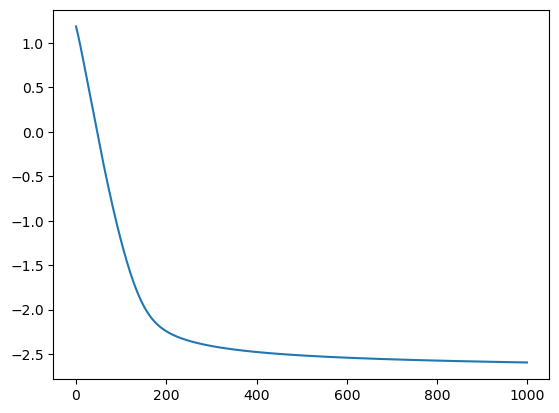

In [449]:
plt.plot(loss_vals)

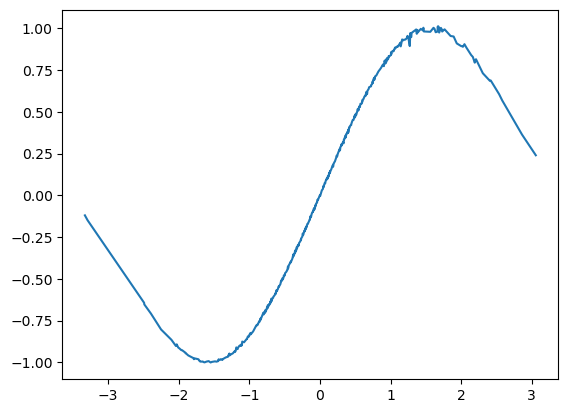

In [450]:
ord = np.argsort(X_test,axis=0)
plt.plot(X_test[ord[:,0],0],preds.mean.numpy()[ord[:,0]])

Un GP con additive kernel...

In [451]:
class AdditiveGP(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, d, max_degree):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(X_train, y_train, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([d]), ard_num_dims=1)
        )
        self.max_degree = max_degree

    def forward(self, X):
        mean = self.mean_module(X)
        batched_dimensions_of_X = X.mT.unsqueeze(-1)  # Now a d x n x 1 tensor
        univariate_rbf_covars = self.covar_module(batched_dimensions_of_X)
        covar = gpytorch.utils.sum_interaction_terms(
            univariate_rbf_covars, max_degree=self.max_degree, dim=-3
        )
        covar = covar + torch.eye(*covar.shape) * 1e-6
        return gpytorch.distributions.MultivariateNormal(mean, covar)
    
max_degree = 1
model = AdditiveGP(to_torch(X_train),to_torch(y_train),X_train.shape[1],max_degree)

model.train()

# Use the adam optimizer
optimizer = torch.optim.Adam( model.parameters(), 
lr=0.05)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

training_iterations = 1000
loss_vals = []
iterator = tqdm.notebook.tqdm(range(training_iterations))
for i in iterator:
    # Zero backprop gradients
    optimizer.zero_grad()
    # Get output from model
    output = model(to_torch(X_train))
    # Calc loss and backprop derivatives
    loss = -mll(output, to_torch(y_train))
    loss.backward()
    optimizer.step()
    loss_vals.append(loss.item())
        
model.eval()

with torch.no_grad():
    preds = model.likelihood(model(to_torch(X_test)))

print(negative_log_predictive_density(preds, to_torch(y_test)).numpy(), 
      mean_standardized_log_loss(preds,to_torch(y_test)).numpy(),
      )
print(np.sqrt(mean_squared_error(preds,to_torch(y_test)).numpy()))  

  0%|          | 0/1000 [00:00<?, ?it/s]

-3.189167987490226 -3.1614182297314737
0.01163635987334405


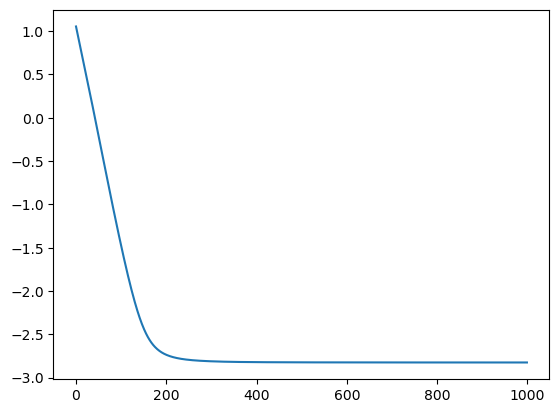

In [452]:
plt.plot(loss_vals)

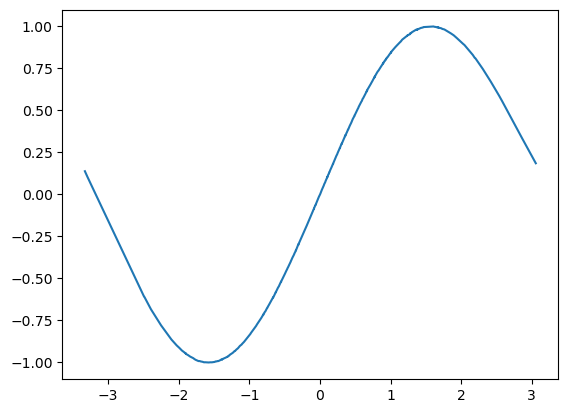

In [453]:
ord = np.argsort(X_test,axis=0)
plt.plot(X_test[ord[:,0],0],preds.mean.numpy()[ord[:,0]])

## BACK UP GP

GP with additive kernel on randomly/learned projected blocks (with random P_projs we are implementing a special case in Delbridge's paper)

In [381]:
class BlockAdditiveGP(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train,P_projs,max_degree):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(X_train, y_train, likelihood)

        num_projs, _,proj_dim = P_projs.shape

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_projs]), ard_num_dims=proj_dim)
        )
        self.max_degree = max_degree
        self.P_projs = torch.nn.Parameter(data=P_projs.clone())
        # self.P_projs = P_projs

    def forward(self, X):
        mean = self.mean_module(X)
        batched_X = torch.matmul(X,self.P_projs) # num_projs, N, proj_dim

        batched_rbf_covars = self.covar_module(batched_X) # num_projs, N, N
        covar = gpytorch.utils.sum_interaction_terms(
            batched_rbf_covars, max_degree=self.max_degree, dim=-3
        ) # N, N
        covar = covar + torch.eye(*covar.shape) * 1e-6
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [382]:
num_projs = 1
proj_dim = 1 #X_train.shape[1]//2
# np.random.seed(3)
P_projs =  np.random.randn(num_projs,X_train.shape[1], proj_dim) / proj_dim
print(P_projs.shape)

torch.matmul(to_torch(X_train),to_torch(P_projs)).shape

(1, 5, 1)


torch.Size([1, 100, 1])

In [383]:
max_order = 1
model = BlockAdditiveGP(to_torch(X_train), to_torch(y_train), to_torch(P_projs),max_order)


# Use the adam optimizer
optimizer = torch.optim.Adam( model.parameters(), lr=0.05)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

training_iterations = 1000
loss_vals = []
iterator = tqdm.notebook.tqdm(range(training_iterations))
for i in iterator:
    # Zero backprop gradients
    optimizer.zero_grad()
    # Get output from model
    output = model(to_torch(X_train))
    # Calc loss and backprop derivatives
    gp_loss = -mll(output, to_torch(y_train))
    # l1_loss = torch.linalg.matrix_norm(model.P_projs, ord=1).sum()
    loss = gp_loss #+ 1 * l1_loss
    loss.backward()
    # iterator.set_postfix(loss=loss.item())
    optimizer.step()
    loss_vals.append(loss.item())
        
model.eval()


with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = model.likelihood(model(to_torch(X_test)))

print(negative_log_predictive_density(preds, to_torch(y_test)).numpy(), 
      mean_standardized_log_loss(preds,to_torch(y_test)).numpy(),
      )
print(np.sqrt(mean_squared_error(preds,to_torch(y_test)).numpy()))

  0%|          | 0/1000 [00:00<?, ?it/s]

-0.6419082392626176 -0.5564307907091862
0.13254732470953223


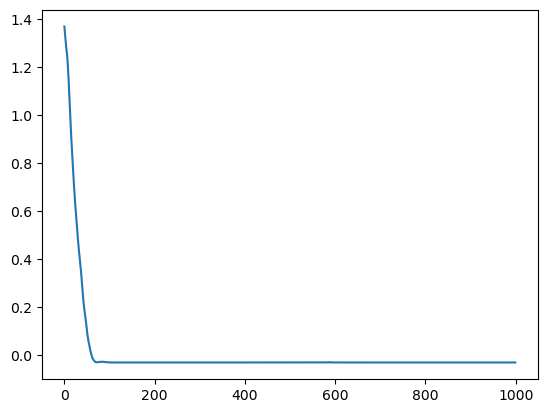

In [384]:
plt.plot(loss_vals)

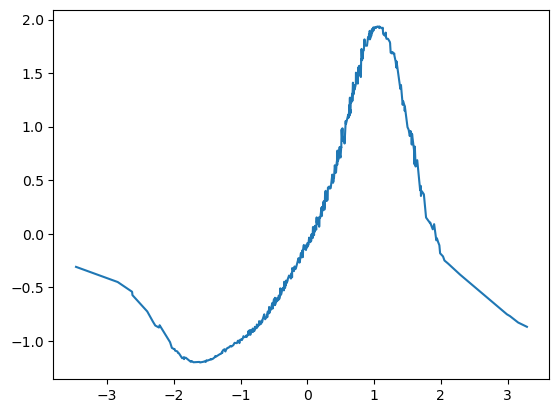

In [385]:
ord = np.argsort(X_test,axis=0)
plt.plot(X_test[ord[:,0],0],preds.mean.numpy()[ord[:,0]])

In [386]:
print(model.P_projs)

Parameter containing:
tensor([[[ 2.6255],
         [-0.0319],
         [ 0.0101],
         [ 0.0103],
         [-0.0381]]], requires_grad=True)


## DKL with GAM GP (already done)

In [387]:
data_dim = X_train.shape[1]

class LargeFeatureExtractor(torch.nn.Sequential):           
    def __init__(self, proj_dim):                                      
        super(LargeFeatureExtractor, self).__init__()        
        self.add_module('linear1', torch.nn.Linear(data_dim, 1000))
        self.add_module('relu1', torch.nn.ReLU())                  
        self.add_module('linear2', torch.nn.Linear(1000, 500))     
        self.add_module('relu2', torch.nn.ReLU())                  
        self.add_module('linear3', torch.nn.Linear(500, 50))       
        self.add_module('relu3', torch.nn.ReLU())                  
        self.add_module('linear4', torch.nn.Linear(50, proj_dim))    

proj_dim = 1                                                           
feature_extractor = LargeFeatureExtractor(proj_dim)     

In [388]:
class DeepKLAdditiveGP(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, proj_dim, max_degree):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(X_train, y_train, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([proj_dim]), ard_num_dims=1)
        )
        self.max_degree = max_degree

        self.feature_extractor = feature_extractor
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.) # This module will scale the NN features so that they're nice values

    def forward(self, X):
        projected_X = self.feature_extractor(X)
        projected_X = self.scale_to_bounds(projected_X)  # Make the NN values "nice"

        mean = self.mean_module(projected_X)
        batched_dimensions_of_X = projected_X.mT.unsqueeze(-1)  # Now a proj_dim x n x 1 tensor

        univariate_rbf_covars = self.covar_module(batched_dimensions_of_X)
        covar = gpytorch.utils.sum_interaction_terms(
            univariate_rbf_covars, max_degree=self.max_degree, dim=-3
        )
        covar = covar + torch.eye(*covar.shape) * 1e-6
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [389]:
max_degree = 1
model = DeepKLAdditiveGP(to_torch(X_train),to_torch(y_train),proj_dim,max_degree)
# Find optimal model hyperparameters
model.train()

# Use the adam optimizer
optimizer = torch.optim.Adam( model.parameters(),
lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

training_iterations = 1000
loss_vals = []
iterator = tqdm.notebook.tqdm(range(training_iterations))
for i in iterator:
    # Zero backprop gradients
    optimizer.zero_grad()
    # Get output from model
    output = model(to_torch(X_train))
    # Calc loss and backprop derivatives
    loss = -mll(output, to_torch(y_train))
    loss.backward()
    # iterator.set_postfix(loss=loss.item())
    optimizer.step()
    loss_vals.append(loss.item())
        
model.eval()

with torch.no_grad():
    preds = model.likelihood(model(to_torch(X_test)))

print(negative_log_predictive_density(preds, to_torch(y_test)).numpy(), 
      mean_standardized_log_loss(preds,to_torch(y_test)).numpy(),
      )
print(np.sqrt(mean_squared_error(preds,to_torch(y_test)).numpy()))  


  0%|          | 0/1000 [00:00<?, ?it/s]

101.57087025466545 162.03090542900435
0.34123362599745544


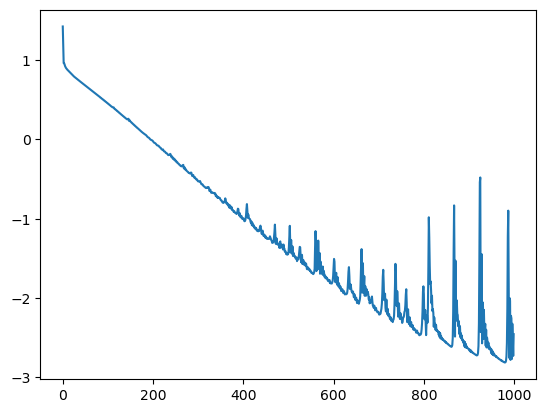

In [390]:
plt.plot(loss_vals)

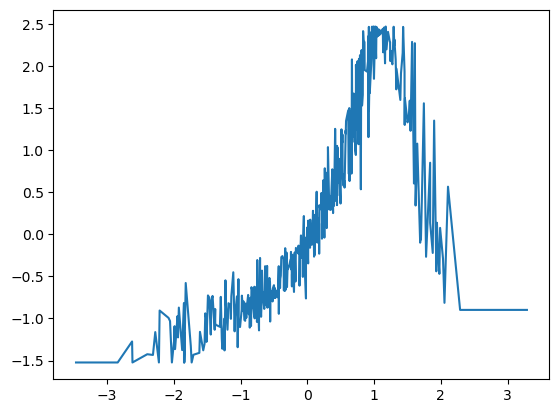

In [391]:
ord = np.argsort(X_test,axis=0)
plt.plot(X_test[ord[:,0],0],preds.mean.numpy()[ord[:,0]])

### DKL sin additive structure

In [392]:
data_dim = X_train.shape[1]

class LargeFeatureExtractor(torch.nn.Sequential):           
    def __init__(self, proj_dim):                                      
        super(LargeFeatureExtractor, self).__init__()        
        self.add_module('linear1', torch.nn.Linear(data_dim, 1000))
        self.add_module('relu1', torch.nn.ReLU())                  
        self.add_module('linear2', torch.nn.Linear(1000, 500))     
        self.add_module('relu2', torch.nn.ReLU())                  
        self.add_module('linear3', torch.nn.Linear(500, 50))       
        self.add_module('relu3', torch.nn.ReLU())                  
        self.add_module('linear4', torch.nn.Linear(50, proj_dim))    

proj_dim = 1                                                           
feature_extractor = LargeFeatureExtractor(proj_dim)


class DeepKLGP(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, proj_dim):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(X_train, y_train, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=proj_dim)
        )
        self.feature_extractor = feature_extractor
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.) # This module will scale the NN features so that they're nice values

    def forward(self, X):
        projected_X = self.feature_extractor(X)
        projected_X = self.scale_to_bounds(projected_X)  # Make the NN values "nice"

        mean = self.mean_module(projected_X)
        covar = self.covar_module(projected_X)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [393]:
model = DeepKLGP(to_torch(X_train),to_torch(y_train),proj_dim)
# Find optimal model hyperparameters
model.train()

# Use the adam optimizer
optimizer = torch.optim.Adam( model.parameters(),
lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

training_iterations = 1000
loss_vals = []
iterator = tqdm.notebook.tqdm(range(training_iterations))
for i in iterator:
    # Zero backprop gradients
    optimizer.zero_grad()
    # Get output from model
    output = model(to_torch(X_train))
    # Calc loss and backprop derivatives
    loss = -mll(output, to_torch(y_train))
    loss.backward()
    # iterator.set_postfix(loss=loss.item())
    optimizer.step()
    loss_vals.append(loss.item())
        
model.eval()

with torch.no_grad():
    preds = model.likelihood(model(to_torch(X_test)))

print(negative_log_predictive_density(preds, to_torch(y_test)).numpy(), 
      mean_standardized_log_loss(preds,to_torch(y_test)).numpy(),
      )
print(np.sqrt(mean_squared_error(preds,to_torch(y_test)).numpy()))  


  0%|          | 0/1000 [00:00<?, ?it/s]

99.62959204112057 152.58884512062195
0.2974385405352706


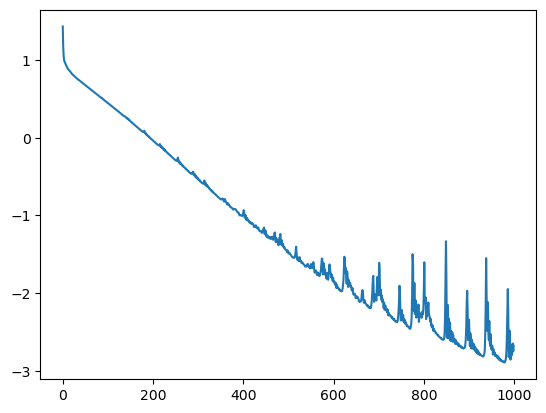

In [394]:
plt.plot(loss_vals)

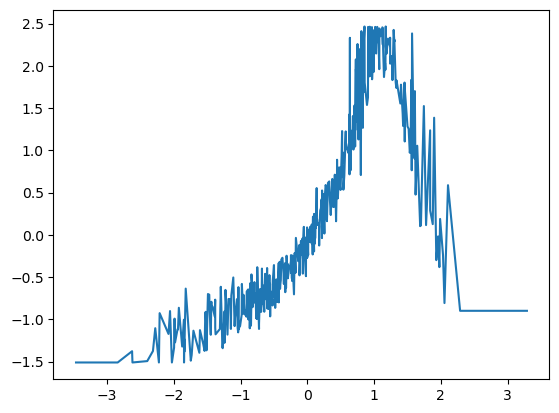

In [395]:
ord = np.argsort(X_test,axis=0)
plt.plot(X_test[ord[:,0],0],preds.mean.numpy()[ord[:,0]])

# Comparison as we increase d (but p=1 fixed) with different noise levels

In [471]:
class vanillaGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, kernel=None, mean=None):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super(vanillaGP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = mean or gpytorch.means.ConstantMean()
        self.covar_module = kernel or gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

class AdditiveGP(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, max_degree):   # if max_degree = 1 --> GAM-GP
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(X_train, y_train, likelihood)

        d = X_train.shape[1]

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([d]), ard_num_dims=1)
        )
        self.max_degree = max_degree

    def forward(self, X):
        mean = self.mean_module(X)
        batched_dimensions_of_X = X.mT.unsqueeze(-1)  # Now a d x n x 1 tensor
        univariate_rbf_covars = self.covar_module(batched_dimensions_of_X)
        covar = gpytorch.utils.sum_interaction_terms(
            univariate_rbf_covars, max_degree=self.max_degree, dim=-3
        )
        covar = covar + torch.eye(*covar.shape) * 1e-6
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    
class BlockAdditiveGPWithRP(gpytorch.models.ExactGP):         
    def __init__(self, X_train, y_train,P_projs,max_degree):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(X_train, y_train, likelihood)

        num_projs, _,proj_dim = P_projs.shape

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_projs]), ard_num_dims=proj_dim)
        )
        self.max_degree = max_degree
        self.P_projs = P_projs   # if P_projs = torch.eye(X_train.shape[1]).unsqueeze(-1), it is equivalent to additiveGP

    def forward(self, X):
        mean = self.mean_module(X)
        batched_X = torch.matmul(X,self.P_projs) # num_projs, N, proj_dim

        batched_rbf_covars = self.covar_module(batched_X) # num_projs, N, N
        covar = gpytorch.utils.sum_interaction_terms(
            batched_rbf_covars, max_degree=self.max_degree, dim=-3
        ) # N, N
        covar = covar + torch.eye(*covar.shape) * 1e-6
        return gpytorch.distributions.MultivariateNormal(mean, covar)     
    

# sin saberlo, he programado aqui abajo un projection pursuit GP:
# se aprenden unas matrices de proyeccion y se aplica un kernel (aditivo si hay mas de una proyeccion)
class BlockAdditiveGPWithLP(gpytorch.models.ExactGP):        # here we learn a unique P_proj
    def __init__(self, X_train, y_train,P_projs,max_degree):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(X_train, y_train, likelihood)

        num_projs, _,proj_dim = P_projs.shape
        assert num_projs == 1
        assert _ == X_train.shape[1]

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_projs]), ard_num_dims=proj_dim)
        )
        self.max_degree = max_degree
        self.P_projs = torch.nn.Parameter(data=P_projs.clone())   # learning also the projections

    def forward(self, X):
        mean = self.mean_module(X)
        batched_X = torch.matmul(X,self.P_projs) # num_projs, N, proj_dim

        batched_rbf_covars = self.covar_module(batched_X) # num_projs, N, N
        covar = gpytorch.utils.sum_interaction_terms(
            batched_rbf_covars, max_degree=self.max_degree, dim=-3
        ) # N, N
        covar = covar + torch.eye(*covar.shape) * 1e-6
        return gpytorch.distributions.MultivariateNormal(mean, covar)      


class LargeFeatureExtractor(torch.nn.Sequential):           
    def __init__(self, proj_dim):                                      
        super(LargeFeatureExtractor, self).__init__()        
        self.add_module('linear1', torch.nn.Linear(X_train.shape[1], 500))
        self.add_module('relu1', torch.nn.ReLU())                  
        self.add_module('linear2', torch.nn.Linear(500, 250))     
        self.add_module('relu2', torch.nn.ReLU())                  
        self.add_module('linear3', torch.nn.Linear(250, 50))       
        self.add_module('relu3', torch.nn.ReLU())                  
        self.add_module('linear4', torch.nn.Linear(50, proj_dim))       


class DeepKLGP(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, feature_extractor,proj_dim):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(X_train, y_train, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=proj_dim)
        )
        self.feature_extractor = feature_extractor
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.) # This module will scale the NN features so that they're nice values

    def forward(self, X):
        projected_X = self.feature_extractor(X)
        projected_X = self.scale_to_bounds(projected_X)  # Make the NN values "nice"

        mean = self.mean_module(projected_X)
        covar = self.covar_module(projected_X)
        return gpytorch.distributions.MultivariateNormal(mean, covar)            


class DeepKLAdditiveGP(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, feature_extractor,proj_dim, max_degree):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(X_train, y_train, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([proj_dim]), ard_num_dims=1)
        )
        self.max_degree = max_degree

        self.feature_extractor = feature_extractor
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.) # This module will scale the NN features so that they're nice values

    def forward(self, X):
        projected_X = self.feature_extractor(X)
        projected_X = self.scale_to_bounds(projected_X)  # Make the NN values "nice"

        mean = self.mean_module(projected_X)
        batched_dimensions_of_X = projected_X.mT.unsqueeze(-1)  # Now a proj_dim x n x 1 tensor

        univariate_rbf_covars = self.covar_module(batched_dimensions_of_X)
        covar = gpytorch.utils.sum_interaction_terms(
            univariate_rbf_covars, max_degree=self.max_degree, dim=-3
        )
        covar = covar + torch.eye(*covar.shape) * 1e-6
        return gpytorch.distributions.MultivariateNormal(mean, covar)      

   

In [472]:
def multimodal_d_dim(x):
    n, d = x.shape
    centers = [torch.zeros(1, d).to(x) for _ in range(d)]
    for i in range(d):
        centers[i][0,i] = 1.
        centers[i][0,:i] = -1.
        centers[i][0,i+1:] = -1.
    total = 0
    for i in range(d):
        total = total + torch.exp(-torch.norm(x - centers[i], dim=1))
    return total



def normalize_data(X_train,y_train,X_test,y_test):
    mean, std = X_train.mean(0), X_train.std(0)
    X_train = (X_train - mean)/ std
    X_test = (X_test - mean)/ std

    mean, std = y_train.mean(0), y_train.std(0)
    y_train = ((y_train - mean)/ std).squeeze()
    y_test = ((y_test - mean)/ std).squeeze()

    return X_train, y_train, X_test, y_test


In [503]:
from tqdm import tqdm
num_projs = 20
p = 5   # active dimensions
sn = 0.1

d_vals = [p,5*p,10*p,20*p]


rmse = np.empty((len(d_vals),5))
nlpd = np.empty((len(d_vals),5))

for k,d in tqdm(enumerate(d_vals)):
    # Create the dataset
    # X_train = np.random.randn(100, d)
    # y_train =  multimodal_d_dim(to_torch(X_train)[:, :p]) + torch.randn(X_train.shape[0]) * sn

    # X_test = np.random.randn(500, d)
    # y_test = multimodal_d_dim(to_torch(X_test)[:, :p]) #+ torch.randn(X_test.shape[0]) * sn

    X_train = np.random.randn(100, d)
    y_train = np.sin(X_train[:,:p]).sum(axis=1) + np.random.randn(100) * sn
    X_test = np.random.randn(500, d)
    y_test = np.sin(X_test[:,:p]).sum(axis=1) #+ np.random.randn(500)  * sn
    y_train = y_train.squeeze()
    y_test = y_test.squeeze()

    X_train, y_train, X_test, y_test = normalize_data(X_train, y_train, X_test, y_test)


    proj_dim = p
    P_projs =  torch.randn(num_projs,X_train.shape[1], proj_dim) / proj_dim
    feature_extractor = LargeFeatureExtractor(proj_dim)
    models = [
        vanillaGP(to_torch(X_train),to_torch(y_train)),
        AdditiveGP(to_torch(X_train),to_torch(y_train), 1),   # max_order = GAM-GP
        DeepKLGP(to_torch(X_train),to_torch(y_train),feature_extractor,proj_dim),
        BlockAdditiveGPWithRP(to_torch(X_train),to_torch(y_train),P_projs,1),  # max_order = 1
        BlockAdditiveGPWithLP(to_torch(X_train),to_torch(y_train),torch.randn(1,X_train.shape[1],proj_dim),1),  # we learn a single projection 
    ]

    for m,model in enumerate(models):
        model.train()
        optimizer = torch.optim.Adam( model.parameters(),lr=0.01)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

        training_iterations = 1000
        # iterator = tqdm.notebook.tqdm(range(training_iterations))
        for i in range(training_iterations):
            optimizer.zero_grad()
            output = model(to_torch(X_train))
            loss = -mll(output, to_torch(y_train))
            loss.backward()
            optimizer.step()
                
        model.eval()
        with torch.no_grad():
            preds = model.likelihood(model(to_torch(X_test)))

        nlpd[k,m] = negative_log_predictive_density(preds, to_torch(y_test)).numpy()
        # mean_standardized_log_loss(preds,to_torch(y_test)).numpy(),    
        rmse[k,m] = np.sqrt(mean_squared_error(preds,to_torch(y_test)).numpy())


            

4it [00:49, 12.35s/it]


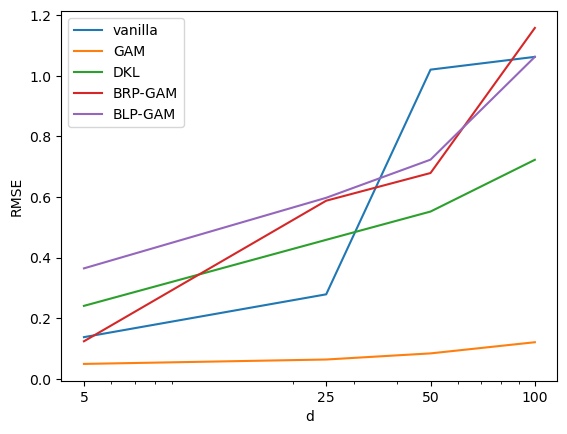

In [504]:
from matplotlib.ticker import ScalarFormatter
fig,ax = plt.subplots()
labels = ['vanilla', 'GAM', 'DKL', 'BRP-GAM', 'BLP-GAM']
for m in range(len(labels)):
    plt.plot(d_vals,rmse[:,m], label = labels[m])

ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
# ax.minorticks_off()
ax.set_xticks(d_vals)
ax.set_ylabel('RMSE')
ax.set_xlabel('d')
ax.legend()   

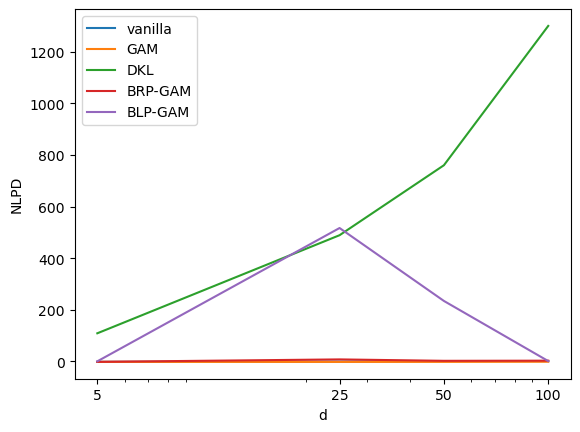

In [505]:
from matplotlib.ticker import ScalarFormatter
fig,ax = plt.subplots()
labels = ['vanilla', 'GAM', 'DKL', 'BRP-GAM', 'BLP-GAM']
for m in range(len(labels)):
    plt.plot(d_vals,nlpd[:,m], label = labels[m])

ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
# ax.minorticks_off()
ax.set_xticks(d_vals)
ax.set_ylabel('NLPD')
ax.set_xlabel('d')
ax.legend()   